# Computer Assignment 4: CNN Segmentation
## Alaqian Zafar - aaz7118

## Table of Contents
- <a href='#p1a'>Part (a)</a>
- <a href='#p1b'>Part (b)</a>
- <a href='#p1c'>Part (c)</a>
    - [Architecture](#Architecture)
    - [Loss Function](#Loss-Function)
- <a href='#p1d'>Part (d)</a>
- <a href='#p2a'>Part (e)</a>
- <a href='#p2b'>Part (f)</a>
- <a href='#p2c'>Part (g)</a>

In [1]:
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm import tqdm

%matplotlib inline

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/ECE-GY 6123 Image and Video Processing/Computer Assignments/CA04/archive'
except:
    path = 'archive'

<a id='p1a'></a>
##### (a) Cut the FudanPed dataset into an 80-10-10 train-val-test split.

[Table of Contents](#Table-of-Contents)

In [3]:
image_paths = sorted([os.path.join(path, "PNGImages", image) for image in os.listdir(os.path.join(path, "PNGImages"))])
mask_paths = sorted([os.path.join(path, "PedMasks", mask) for mask in os.listdir(os.path.join(path, "PedMasks"))])

indices = list(range(len(image_paths)))
train_indices = random.sample(indices, k=int(len(indices)*0.8))
val_indices = random.sample(set(indices)-set(train_indices), k=int(len(indices)*0.1))
test_indices = list(set(indices)-set(train_indices)-set(val_indices))

train_image_paths = [image_paths[i] for i in train_indices]
train_mask_paths = [mask_paths[i] for i in train_indices]
val_image_paths = [image_paths[i] for i in val_indices]
val_mask_paths = [mask_paths[i] for i in val_indices]
test_image_paths = [image_paths[i] for i in test_indices]
test_mask_paths = [mask_paths[i] for i in test_indices]

class PennFudanDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], 0)
        # Set all values greater-than or equal-to 1 to 255.
        mask = np.clip(mask, 0, 1)*255
        merged_image = np.concatenate((image, mask[:, :, None]), axis=2)
        merged_image = transforms.ToTensor()(merged_image)
        if self.transform:
            merged_image = self.transform(merged_image)
        image = merged_image[:3, :, :]
        mask = merged_image[3, :, :]
        return image, mask

<a id='p1b'></a>
##### (b) Apply data augmentation to your dataset during training and show an example of your data augmentation in your report.

[Table of Contents](#Table-of-Contents)

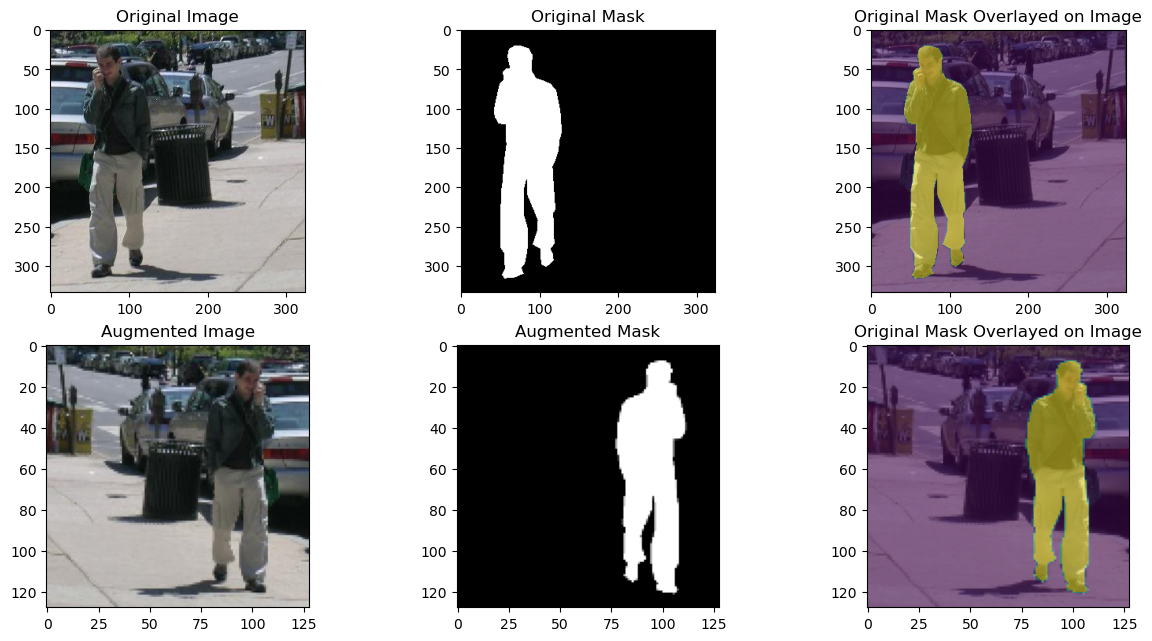

In [4]:
# Plot a subplot of the original and the augmented image and mask
train_dataset = PennFudanDataset(train_image_paths, train_mask_paths)
image, mask = train_dataset[0]
fig, ax = plt.subplots(2, 3, figsize=(15, 7.5))
ax[0,0].imshow(image.permute(1, 2, 0))
ax[0,0].set_title("Original Image")
ax[0,1].imshow(mask, cmap="gray")
ax[0,1].set_title("Original Mask")
ax[0,2].imshow(image.permute(1, 2, 0))
ax[0,2].imshow(mask, alpha=0.5)
ax[0,2].set_title("Original Mask Overlayed on Image")

image_size = (128,128)
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(image_size)
    ])
augmented_train_dataset = PennFudanDataset(train_image_paths, train_mask_paths, transform=augmentation)
image, mask = augmented_train_dataset[0]
ax[1,0].imshow(image.permute(1, 2, 0))
ax[1,0].set_title("Augmented Image")
ax[1,1].imshow(mask, cmap="gray")
ax[1,1].set_title("Augmented Mask")
ax[1,2].imshow(image.permute(1, 2, 0))
ax[1,2].imshow(mask, alpha=0.5)
ax[1,2].set_title("Original Mask Overlayed on Image")

batchsize = 8

train_loader = DataLoader(augmented_train_dataset, batch_size=batchsize, shuffle=True)
test_dataset = PennFudanDataset(
    test_image_paths,
    test_mask_paths, 
    transform=transforms.Resize(image_size))
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)
val_dataset = PennFudanDataset(
    val_image_paths, 
    val_mask_paths, 
    transform=transforms.Resize(image_size))
val_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

<a id='p1c'></a>
##### (c) Implement and train a CNN for binary segmentation on your train split. Describe your network architecture, loss function, and any training hyper-parameters. You may implement any architecture you'd like, **but the implementation must be your own code.**

[Table of Contents](#Table-of-Contents)

#### Architecture

`x` (input) → `Conv_BN_ReLU1` → `Downsample1` → `x1` → `x2` → `Conv_BN_ReLU2` → `x3` → `Downsample2` → `x4` → `Conv_BN_ReLU3` → `x5` → `Upsample1` → `x6` → `cat(x3)` → `x7` → `Conv_BN_ReLU4` → `x8` → `Upsamle2` → `x9` → `cat(x1)` → `x10` → `Conv_BN_ReLU5` → `x11` → `conv6` → `x12` → `sigmoid` → `x13` (output)

![Architecture](UNET.png)

In [5]:
class UNET(nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        self.Conv_BN_ReLU1 = self._Conv_BN_ReLU(3, 16)
        self.Downsample1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Conv_BN_ReLU2 = self._Conv_BN_ReLU(16, 32)
        self.Downsample2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Conv_BN_ReLU3 = self._Conv_BN_ReLU(32, 32)
        self.Upsample1 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.Conv_BN_ReLU4 = self._Conv_BN_ReLU(64, 16)
        self.Upsample2 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.Conv_BN_ReLU5 = self._Conv_BN_ReLU(32, 16)
        self.Conv6 = nn.Conv2d(16, 1, kernel_size=1)

    def _Conv_BN_ReLU(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x1 = self.Conv_BN_ReLU1(x) # 3x128x128 -> 16x128x128
        x2 = self.Downsample1(x1) # 16x128x128 -> 16x64x64
        x3 = self.Conv_BN_ReLU2(x2) # 16x64x64 -> 32x64x64
        x4 = self.Downsample2(x3) # 32x64x64 -> 32x32x32
        x5 = self.Conv_BN_ReLU3(x4) # 32x32x32 -> 32x32x32\
        x6 = self.Upsample1(x5) # 32x32x32 -> 32x64x64
        x7 = torch.cat((x6, x3), dim=1) # 32x64x64 + 32x64x64 -> 64x64x64
        x8 = self.Conv_BN_ReLU4(x7) # 64x64x64 -> 16x64x64
        x9 = self.Upsample2(x8) # 16x64x64 -> 16x128x128
        x10 = torch.cat((x9, x1), dim=1) # 16x128x128 + 16x128x128 -> 32x128x128
        x11 = self.Conv_BN_ReLU5(x10) # 32x128x128 -> 16x128x128
        x12 = self.Conv6(x11) # 16x128x128 -> 1x128x128
        x13 = torch.sigmoid(x12) # 1x128x128 -> 1x128x128
        return x13

#### Loss Function

[Table of Contents](#Table-of-Contents)

In [6]:
def dice_coefficient(pred, target):
    smooth = 1.
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

class SoftDiceLoss(nn.Module):
    def __init__(self):
        super(SoftDiceLoss, self).__init__()
    
    def forward(self, pred, target):
        smooth = 1.
        pred = pred.view(-1)
        target = target.view(-1)
        intersection = (pred * target).sum()
        return 1 - (2. * intersection + smooth) / ((pred ** 2).sum() + (target ** 2).sum() + smooth)

#### Training

[Table of Contents](#Table-of-Contents)

In [7]:
def save_checkpoint(filename, model, optimizer, epoch, val_loss):
    torch.save({
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch,
        "loss": val_loss}, filename)
    
def load_checkpoint(filename, model, optimizer):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    return model, optimizer, epoch, loss

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    for image, mask in train_loader:
        image = image.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        pred = model(image)
        loss = criterion(pred, mask[:,None,:,:])
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

def evaluate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for image, mask in val_loader:
            image = image.to(device)
            mask = mask.to(device)
            pred = model(image)
            loss = criterion(pred, mask[:,None,:,:])
            val_loss += loss.item()
    return val_loss / len(val_loader)


NUM_EPOCHS = 1000
learning_rate=0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNET().to(device)
criterion = SoftDiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
checkpoint_dir = "./checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")

if os.path.exists(checkpoint_path):
    model, optimizer, start_epoch, val_loss = load_checkpoint(checkpoint_path, model, optimizer)
    print("Checkpoint loaded: start epoch = {}, val loss = {}".format(start_epoch, val_loss))
else:
    start_epoch = 0
    val_loss = np.inf

train_losses = []
val_losses = []
for epoch in range(start_epoch, start_epoch+NUM_EPOCHS):
    progress_bar = tqdm(train_loader)
    train_loss = train(model, progress_bar, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    print("Epoch: {}/{}...".format(epoch+1, start_epoch+NUM_EPOCHS),
            "Train Loss: {:.4f}...".format(train_loss),
            "Val Loss: {:.4f}".format(val_loss))
    train_losses.append(train_loss)
    val_losses.append(val_loss)
save_checkpoint(checkpoint_path, model, optimizer, epoch, val_loss)


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch: 1/1000... Train Loss: 0.5317... Val Loss: 0.6669


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 2/1000... Train Loss: 0.4632... Val Loss: 0.6107


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 3/1000... Train Loss: 0.4250... Val Loss: 0.4508


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 4/1000... Train Loss: 0.3848... Val Loss: 0.4242


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]


Epoch: 5/1000... Train Loss: 0.3505... Val Loss: 0.3928


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 6/1000... Train Loss: 0.3281... Val Loss: 0.3651


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 7/1000... Train Loss: 0.3055... Val Loss: 0.3476


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch: 8/1000... Train Loss: 0.2838... Val Loss: 0.3475


100%|██████████| 17/17 [00:05<00:00,  3.21it/s]


Epoch: 9/1000... Train Loss: 0.2603... Val Loss: 0.2790


100%|██████████| 17/17 [00:05<00:00,  3.21it/s]


Epoch: 10/1000... Train Loss: 0.2612... Val Loss: 0.2596


100%|██████████| 17/17 [00:05<00:00,  3.21it/s]


Epoch: 11/1000... Train Loss: 0.2646... Val Loss: 0.3096


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 12/1000... Train Loss: 0.2428... Val Loss: 0.3069


100%|██████████| 17/17 [00:05<00:00,  3.22it/s]


Epoch: 13/1000... Train Loss: 0.2258... Val Loss: 0.2598


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]


Epoch: 14/1000... Train Loss: 0.2126... Val Loss: 0.2434


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 15/1000... Train Loss: 0.2040... Val Loss: 0.2128


100%|██████████| 17/17 [00:05<00:00,  3.22it/s]


Epoch: 16/1000... Train Loss: 0.2103... Val Loss: 0.2480


100%|██████████| 17/17 [00:05<00:00,  3.22it/s]


Epoch: 17/1000... Train Loss: 0.2042... Val Loss: 0.2112


100%|██████████| 17/17 [00:05<00:00,  3.22it/s]


Epoch: 18/1000... Train Loss: 0.1853... Val Loss: 0.1899


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 19/1000... Train Loss: 0.1725... Val Loss: 0.2101


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 20/1000... Train Loss: 0.1719... Val Loss: 0.2145


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 21/1000... Train Loss: 0.1709... Val Loss: 0.1977


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 22/1000... Train Loss: 0.1671... Val Loss: 0.2807


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch: 23/1000... Train Loss: 0.1659... Val Loss: 0.1969


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch: 24/1000... Train Loss: 0.1580... Val Loss: 0.2019


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 25/1000... Train Loss: 0.1563... Val Loss: 0.1852


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 26/1000... Train Loss: 0.1532... Val Loss: 0.2208


100%|██████████| 17/17 [00:05<00:00,  3.28it/s]


Epoch: 27/1000... Train Loss: 0.1565... Val Loss: 0.2207


100%|██████████| 17/17 [00:05<00:00,  3.22it/s]


Epoch: 28/1000... Train Loss: 0.1476... Val Loss: 0.2398


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 29/1000... Train Loss: 0.1487... Val Loss: 0.1698


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 30/1000... Train Loss: 0.1381... Val Loss: 0.2143


100%|██████████| 17/17 [00:05<00:00,  3.31it/s]


Epoch: 31/1000... Train Loss: 0.1452... Val Loss: 0.1940


100%|██████████| 17/17 [00:05<00:00,  3.28it/s]


Epoch: 32/1000... Train Loss: 0.1429... Val Loss: 0.2009


100%|██████████| 17/17 [00:05<00:00,  3.37it/s]


Epoch: 33/1000... Train Loss: 0.1258... Val Loss: 0.2093


100%|██████████| 17/17 [00:05<00:00,  3.26it/s]


Epoch: 34/1000... Train Loss: 0.1268... Val Loss: 0.2209


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 35/1000... Train Loss: 0.1257... Val Loss: 0.2083


100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch: 36/1000... Train Loss: 0.1244... Val Loss: 0.2136


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch: 37/1000... Train Loss: 0.1200... Val Loss: 0.1904


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 38/1000... Train Loss: 0.1155... Val Loss: 0.1943


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 39/1000... Train Loss: 0.1088... Val Loss: 0.2781


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 40/1000... Train Loss: 0.1125... Val Loss: 0.2446


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 41/1000... Train Loss: 0.1157... Val Loss: 0.1847


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 42/1000... Train Loss: 0.1239... Val Loss: 0.2237


100%|██████████| 17/17 [00:06<00:00,  2.75it/s]


Epoch: 43/1000... Train Loss: 0.1143... Val Loss: 0.1781


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 44/1000... Train Loss: 0.1089... Val Loss: 0.1806


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 45/1000... Train Loss: 0.1018... Val Loss: 0.2346


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 46/1000... Train Loss: 0.0949... Val Loss: 0.2238


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 47/1000... Train Loss: 0.1002... Val Loss: 0.1863


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 48/1000... Train Loss: 0.0976... Val Loss: 0.2009


100%|██████████| 17/17 [00:05<00:00,  3.30it/s]


Epoch: 49/1000... Train Loss: 0.0967... Val Loss: 0.2103


100%|██████████| 17/17 [00:05<00:00,  3.29it/s]


Epoch: 50/1000... Train Loss: 0.0943... Val Loss: 0.1589


100%|██████████| 17/17 [00:05<00:00,  3.30it/s]


Epoch: 51/1000... Train Loss: 0.1051... Val Loss: 0.2130


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 52/1000... Train Loss: 0.1096... Val Loss: 0.2465


100%|██████████| 17/17 [00:06<00:00,  2.75it/s]


Epoch: 53/1000... Train Loss: 0.1000... Val Loss: 0.1762


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 54/1000... Train Loss: 0.0949... Val Loss: 0.1725


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 55/1000... Train Loss: 0.0852... Val Loss: 0.2170


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 56/1000... Train Loss: 0.0799... Val Loss: 0.2412


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 57/1000... Train Loss: 0.0814... Val Loss: 0.1857


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 58/1000... Train Loss: 0.0839... Val Loss: 0.2198


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 59/1000... Train Loss: 0.0792... Val Loss: 0.2116


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 60/1000... Train Loss: 0.0770... Val Loss: 0.2070


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 61/1000... Train Loss: 0.0735... Val Loss: 0.1510


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 62/1000... Train Loss: 0.0745... Val Loss: 0.2148


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 63/1000... Train Loss: 0.0705... Val Loss: 0.1741


100%|██████████| 17/17 [00:05<00:00,  2.93it/s]


Epoch: 64/1000... Train Loss: 0.0811... Val Loss: 0.2014


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch: 65/1000... Train Loss: 0.0785... Val Loss: 0.2120


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 66/1000... Train Loss: 0.0755... Val Loss: 0.2191


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 67/1000... Train Loss: 0.0714... Val Loss: 0.1989


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 68/1000... Train Loss: 0.0734... Val Loss: 0.2212


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 69/1000... Train Loss: 0.0740... Val Loss: 0.1723


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 70/1000... Train Loss: 0.0722... Val Loss: 0.2009


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch: 71/1000... Train Loss: 0.0649... Val Loss: 0.1763


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 72/1000... Train Loss: 0.0602... Val Loss: 0.1656


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 73/1000... Train Loss: 0.0647... Val Loss: 0.2944


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 74/1000... Train Loss: 0.0640... Val Loss: 0.1853


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 75/1000... Train Loss: 0.0684... Val Loss: 0.1775


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 76/1000... Train Loss: 0.0602... Val Loss: 0.1883


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 77/1000... Train Loss: 0.0622... Val Loss: 0.1644


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 78/1000... Train Loss: 0.0817... Val Loss: 0.2354


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 79/1000... Train Loss: 0.0790... Val Loss: 0.2424


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 80/1000... Train Loss: 0.0820... Val Loss: 0.1931


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 81/1000... Train Loss: 0.0783... Val Loss: 0.1952


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 82/1000... Train Loss: 0.0676... Val Loss: 0.1734


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 83/1000... Train Loss: 0.0670... Val Loss: 0.1805


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 84/1000... Train Loss: 0.0615... Val Loss: 0.1731


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 85/1000... Train Loss: 0.0611... Val Loss: 0.1607


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 86/1000... Train Loss: 0.0578... Val Loss: 0.1544


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 87/1000... Train Loss: 0.0572... Val Loss: 0.1655


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 88/1000... Train Loss: 0.0561... Val Loss: 0.1978


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 89/1000... Train Loss: 0.0561... Val Loss: 0.1619


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 90/1000... Train Loss: 0.0554... Val Loss: 0.1566


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 91/1000... Train Loss: 0.0548... Val Loss: 0.2312


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch: 92/1000... Train Loss: 0.0554... Val Loss: 0.1664


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch: 93/1000... Train Loss: 0.0548... Val Loss: 0.1731


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 94/1000... Train Loss: 0.0523... Val Loss: 0.1869


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 95/1000... Train Loss: 0.0504... Val Loss: 0.1806


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 96/1000... Train Loss: 0.0516... Val Loss: 0.1640


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 97/1000... Train Loss: 0.0593... Val Loss: 0.1789


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 98/1000... Train Loss: 0.0555... Val Loss: 0.2187


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 99/1000... Train Loss: 0.0537... Val Loss: 0.1668


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 100/1000... Train Loss: 0.0519... Val Loss: 0.1859


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 101/1000... Train Loss: 0.0520... Val Loss: 0.1873


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch: 102/1000... Train Loss: 0.0507... Val Loss: 0.1676


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 103/1000... Train Loss: 0.0479... Val Loss: 0.1861


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 104/1000... Train Loss: 0.0516... Val Loss: 0.1708


100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch: 105/1000... Train Loss: 0.0486... Val Loss: 0.2004


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 106/1000... Train Loss: 0.0465... Val Loss: 0.1709


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 107/1000... Train Loss: 0.0500... Val Loss: 0.1672


100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch: 108/1000... Train Loss: 0.0486... Val Loss: 0.2298


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 109/1000... Train Loss: 0.0487... Val Loss: 0.1878


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 110/1000... Train Loss: 0.0492... Val Loss: 0.1701


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 111/1000... Train Loss: 0.0457... Val Loss: 0.1811


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 112/1000... Train Loss: 0.0453... Val Loss: 0.1796


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 113/1000... Train Loss: 0.0433... Val Loss: 0.2366


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 114/1000... Train Loss: 0.0524... Val Loss: 0.1733


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 115/1000... Train Loss: 0.0482... Val Loss: 0.1979


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 116/1000... Train Loss: 0.0465... Val Loss: 0.1844


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch: 117/1000... Train Loss: 0.0417... Val Loss: 0.1783


100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch: 118/1000... Train Loss: 0.0456... Val Loss: 0.1712


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 119/1000... Train Loss: 0.0445... Val Loss: 0.1817


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 120/1000... Train Loss: 0.0445... Val Loss: 0.1642


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 121/1000... Train Loss: 0.0438... Val Loss: 0.1769


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]


Epoch: 122/1000... Train Loss: 0.0429... Val Loss: 0.2150


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 123/1000... Train Loss: 0.0414... Val Loss: 0.1608


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 124/1000... Train Loss: 0.0399... Val Loss: 0.1754


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 125/1000... Train Loss: 0.0402... Val Loss: 0.1702


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 126/1000... Train Loss: 0.0391... Val Loss: 0.1609


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 127/1000... Train Loss: 0.0393... Val Loss: 0.1891


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 128/1000... Train Loss: 0.0467... Val Loss: 0.2016


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 129/1000... Train Loss: 0.0400... Val Loss: 0.1705


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 130/1000... Train Loss: 0.0410... Val Loss: 0.1681


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 131/1000... Train Loss: 0.0429... Val Loss: 0.2040


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 132/1000... Train Loss: 0.0434... Val Loss: 0.1730


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 133/1000... Train Loss: 0.0416... Val Loss: 0.1704


100%|██████████| 17/17 [00:05<00:00,  3.21it/s]


Epoch: 134/1000... Train Loss: 0.0424... Val Loss: 0.1661


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 135/1000... Train Loss: 0.0434... Val Loss: 0.1771


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 136/1000... Train Loss: 0.0432... Val Loss: 0.2022


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 137/1000... Train Loss: 0.0419... Val Loss: 0.2117


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 138/1000... Train Loss: 0.0438... Val Loss: 0.1979


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 139/1000... Train Loss: 0.0411... Val Loss: 0.2074


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 140/1000... Train Loss: 0.0384... Val Loss: 0.1726


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 141/1000... Train Loss: 0.0386... Val Loss: 0.1636


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch: 142/1000... Train Loss: 0.0413... Val Loss: 0.1958


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 143/1000... Train Loss: 0.0408... Val Loss: 0.1861


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 144/1000... Train Loss: 0.0384... Val Loss: 0.1688


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 145/1000... Train Loss: 0.0364... Val Loss: 0.1672


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 146/1000... Train Loss: 0.0377... Val Loss: 0.1683


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 147/1000... Train Loss: 0.0370... Val Loss: 0.1618


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 148/1000... Train Loss: 0.0356... Val Loss: 0.1876


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 149/1000... Train Loss: 0.0350... Val Loss: 0.1655


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 150/1000... Train Loss: 0.0366... Val Loss: 0.1752


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 151/1000... Train Loss: 0.0372... Val Loss: 0.1946


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 152/1000... Train Loss: 0.0354... Val Loss: 0.1906


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 153/1000... Train Loss: 0.0357... Val Loss: 0.1754


100%|██████████| 17/17 [00:05<00:00,  3.21it/s]


Epoch: 154/1000... Train Loss: 0.0371... Val Loss: 0.1682


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 155/1000... Train Loss: 0.0348... Val Loss: 0.1642


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 156/1000... Train Loss: 0.0406... Val Loss: 0.1974


100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch: 157/1000... Train Loss: 0.0397... Val Loss: 0.1917


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 158/1000... Train Loss: 0.0371... Val Loss: 0.1811


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 159/1000... Train Loss: 0.0367... Val Loss: 0.1999


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 160/1000... Train Loss: 0.0392... Val Loss: 0.1940


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 161/1000... Train Loss: 0.0396... Val Loss: 0.1620


100%|██████████| 17/17 [00:05<00:00,  2.95it/s]


Epoch: 162/1000... Train Loss: 0.0385... Val Loss: 0.1617


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 163/1000... Train Loss: 0.0366... Val Loss: 0.1674


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 164/1000... Train Loss: 0.0366... Val Loss: 0.1777


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 165/1000... Train Loss: 0.0375... Val Loss: 0.1881


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 166/1000... Train Loss: 0.0375... Val Loss: 0.1960


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 167/1000... Train Loss: 0.0360... Val Loss: 0.1706


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 168/1000... Train Loss: 0.0360... Val Loss: 0.1529


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 169/1000... Train Loss: 0.0345... Val Loss: 0.1512


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch: 170/1000... Train Loss: 0.0346... Val Loss: 0.1856


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 171/1000... Train Loss: 0.0359... Val Loss: 0.2406


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 172/1000... Train Loss: 0.0344... Val Loss: 0.1705


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 173/1000... Train Loss: 0.0329... Val Loss: 0.2027


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 174/1000... Train Loss: 0.0453... Val Loss: 0.1744


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 175/1000... Train Loss: 0.0536... Val Loss: 0.1901


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 176/1000... Train Loss: 0.0499... Val Loss: 0.1721


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 177/1000... Train Loss: 0.0458... Val Loss: 0.2253


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 178/1000... Train Loss: 0.0425... Val Loss: 0.2419


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 179/1000... Train Loss: 0.0370... Val Loss: 0.1730


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 180/1000... Train Loss: 0.0335... Val Loss: 0.1917


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 181/1000... Train Loss: 0.0322... Val Loss: 0.1739


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 182/1000... Train Loss: 0.0337... Val Loss: 0.1793


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 183/1000... Train Loss: 0.0335... Val Loss: 0.1769


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 184/1000... Train Loss: 0.0369... Val Loss: 0.1956


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 185/1000... Train Loss: 0.0365... Val Loss: 0.1726


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 186/1000... Train Loss: 0.0339... Val Loss: 0.1892


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 187/1000... Train Loss: 0.0341... Val Loss: 0.1794


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 188/1000... Train Loss: 0.0374... Val Loss: 0.1880


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 189/1000... Train Loss: 0.0326... Val Loss: 0.1750


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 190/1000... Train Loss: 0.0335... Val Loss: 0.1756


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 191/1000... Train Loss: 0.0326... Val Loss: 0.1698


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 192/1000... Train Loss: 0.0312... Val Loss: 0.1697


100%|██████████| 17/17 [00:05<00:00,  2.93it/s]


Epoch: 193/1000... Train Loss: 0.0341... Val Loss: 0.1964


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 194/1000... Train Loss: 0.0418... Val Loss: 0.2099


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 195/1000... Train Loss: 0.0398... Val Loss: 0.2243


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 196/1000... Train Loss: 0.0367... Val Loss: 0.1886


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 197/1000... Train Loss: 0.0350... Val Loss: 0.2838


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 198/1000... Train Loss: 0.0333... Val Loss: 0.1782


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 199/1000... Train Loss: 0.0310... Val Loss: 0.1730


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 200/1000... Train Loss: 0.0298... Val Loss: 0.1654


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 201/1000... Train Loss: 0.0327... Val Loss: 0.2098


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 202/1000... Train Loss: 0.0332... Val Loss: 0.1775


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 203/1000... Train Loss: 0.0321... Val Loss: 0.1697


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 204/1000... Train Loss: 0.0297... Val Loss: 0.1725


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 205/1000... Train Loss: 0.0279... Val Loss: 0.1785


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 206/1000... Train Loss: 0.0291... Val Loss: 0.1769


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 207/1000... Train Loss: 0.0292... Val Loss: 0.1850


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 208/1000... Train Loss: 0.0287... Val Loss: 0.1766


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch: 209/1000... Train Loss: 0.0271... Val Loss: 0.1648


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 210/1000... Train Loss: 0.0277... Val Loss: 0.1676


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 211/1000... Train Loss: 0.0277... Val Loss: 0.1682


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 212/1000... Train Loss: 0.0276... Val Loss: 0.1758


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 213/1000... Train Loss: 0.0278... Val Loss: 0.1665


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 214/1000... Train Loss: 0.0296... Val Loss: 0.1588


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 215/1000... Train Loss: 0.0302... Val Loss: 0.1932


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 216/1000... Train Loss: 0.0290... Val Loss: 0.1676


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 217/1000... Train Loss: 0.0282... Val Loss: 0.2173


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch: 218/1000... Train Loss: 0.0282... Val Loss: 0.1832


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 219/1000... Train Loss: 0.0297... Val Loss: 0.1782


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 220/1000... Train Loss: 0.0326... Val Loss: 0.1798


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 221/1000... Train Loss: 0.0318... Val Loss: 0.1767


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 222/1000... Train Loss: 0.0344... Val Loss: 0.1848


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 223/1000... Train Loss: 0.0339... Val Loss: 0.1793


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 224/1000... Train Loss: 0.0393... Val Loss: 0.1744


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 225/1000... Train Loss: 0.0347... Val Loss: 0.1749


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 226/1000... Train Loss: 0.0323... Val Loss: 0.1663


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 227/1000... Train Loss: 0.0290... Val Loss: 0.1749


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 228/1000... Train Loss: 0.0282... Val Loss: 0.1676


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 229/1000... Train Loss: 0.0287... Val Loss: 0.2182


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 230/1000... Train Loss: 0.0318... Val Loss: 0.2240


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 231/1000... Train Loss: 0.0329... Val Loss: 0.1743


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 232/1000... Train Loss: 0.0330... Val Loss: 0.1699


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 233/1000... Train Loss: 0.0317... Val Loss: 0.1557


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 234/1000... Train Loss: 0.0298... Val Loss: 0.1781


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 235/1000... Train Loss: 0.0286... Val Loss: 0.1482


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 236/1000... Train Loss: 0.0305... Val Loss: 0.1985


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 237/1000... Train Loss: 0.0336... Val Loss: 0.1738


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch: 238/1000... Train Loss: 0.0325... Val Loss: 0.1955


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 239/1000... Train Loss: 0.0310... Val Loss: 0.1622


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 240/1000... Train Loss: 0.0292... Val Loss: 0.1803


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 241/1000... Train Loss: 0.0257... Val Loss: 0.1763


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 242/1000... Train Loss: 0.0259... Val Loss: 0.1745


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 243/1000... Train Loss: 0.0256... Val Loss: 0.1710


100%|██████████| 17/17 [00:06<00:00,  2.73it/s]


Epoch: 244/1000... Train Loss: 0.0260... Val Loss: 0.1850


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 245/1000... Train Loss: 0.0249... Val Loss: 0.1612


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 246/1000... Train Loss: 0.0254... Val Loss: 0.1713


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 247/1000... Train Loss: 0.0255... Val Loss: 0.1764


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 248/1000... Train Loss: 0.0247... Val Loss: 0.1664


100%|██████████| 17/17 [00:06<00:00,  2.83it/s]


Epoch: 249/1000... Train Loss: 0.0243... Val Loss: 0.1836


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 250/1000... Train Loss: 0.0258... Val Loss: 0.1683


100%|██████████| 17/17 [00:05<00:00,  3.25it/s]


Epoch: 251/1000... Train Loss: 0.0248... Val Loss: 0.1744


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 252/1000... Train Loss: 0.0236... Val Loss: 0.1888


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 253/1000... Train Loss: 0.0240... Val Loss: 0.1667


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 254/1000... Train Loss: 0.0312... Val Loss: 0.1751


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 255/1000... Train Loss: 0.0338... Val Loss: 0.1666


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 256/1000... Train Loss: 0.0324... Val Loss: 0.1939


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 257/1000... Train Loss: 0.0337... Val Loss: 0.1770


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 258/1000... Train Loss: 0.0410... Val Loss: 0.1558


100%|██████████| 17/17 [00:05<00:00,  2.95it/s]


Epoch: 259/1000... Train Loss: 0.0325... Val Loss: 0.1698


100%|██████████| 17/17 [00:05<00:00,  3.26it/s]


Epoch: 260/1000... Train Loss: 0.0313... Val Loss: 0.1562


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 261/1000... Train Loss: 0.0282... Val Loss: 0.1592


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 262/1000... Train Loss: 0.0292... Val Loss: 0.2459


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 263/1000... Train Loss: 0.0298... Val Loss: 0.1864


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch: 264/1000... Train Loss: 0.0269... Val Loss: 0.2044


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch: 265/1000... Train Loss: 0.0259... Val Loss: 0.1666


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 266/1000... Train Loss: 0.0288... Val Loss: 0.2074


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 267/1000... Train Loss: 0.0298... Val Loss: 0.1817


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 268/1000... Train Loss: 0.0286... Val Loss: 0.3227


100%|██████████| 17/17 [00:06<00:00,  2.46it/s]


Epoch: 269/1000... Train Loss: 0.0275... Val Loss: 0.1778


100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epoch: 270/1000... Train Loss: 0.0270... Val Loss: 0.1734


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 271/1000... Train Loss: 0.0278... Val Loss: 0.1773


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 272/1000... Train Loss: 0.0278... Val Loss: 0.1656


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 273/1000... Train Loss: 0.0261... Val Loss: 0.1959


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch: 274/1000... Train Loss: 0.0271... Val Loss: 0.1708


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 275/1000... Train Loss: 0.0272... Val Loss: 0.1755


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 276/1000... Train Loss: 0.0299... Val Loss: 0.1633


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 277/1000... Train Loss: 0.0259... Val Loss: 0.1625


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 278/1000... Train Loss: 0.0248... Val Loss: 0.1609


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 279/1000... Train Loss: 0.0238... Val Loss: 0.1582


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch: 280/1000... Train Loss: 0.0242... Val Loss: 0.1776


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 281/1000... Train Loss: 0.0243... Val Loss: 0.1688


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 282/1000... Train Loss: 0.0231... Val Loss: 0.1562


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 283/1000... Train Loss: 0.0251... Val Loss: 0.1695


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 284/1000... Train Loss: 0.0237... Val Loss: 0.1613


100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


Epoch: 285/1000... Train Loss: 0.0235... Val Loss: 0.1630


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 286/1000... Train Loss: 0.0234... Val Loss: 0.1552


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 287/1000... Train Loss: 0.0222... Val Loss: 0.1676


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 288/1000... Train Loss: 0.0221... Val Loss: 0.1671


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 289/1000... Train Loss: 0.0229... Val Loss: 0.1637


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 290/1000... Train Loss: 0.0229... Val Loss: 0.1731


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 291/1000... Train Loss: 0.0237... Val Loss: 0.1640


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 292/1000... Train Loss: 0.0239... Val Loss: 0.1952


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 293/1000... Train Loss: 0.0241... Val Loss: 0.1605


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 294/1000... Train Loss: 0.0253... Val Loss: 0.2187


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 295/1000... Train Loss: 0.0309... Val Loss: 0.2022


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 296/1000... Train Loss: 0.0283... Val Loss: 0.1756


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 297/1000... Train Loss: 0.0279... Val Loss: 0.1493


100%|██████████| 17/17 [00:06<00:00,  2.73it/s]


Epoch: 298/1000... Train Loss: 0.0255... Val Loss: 0.1748


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 299/1000... Train Loss: 0.0243... Val Loss: 0.1602


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 300/1000... Train Loss: 0.0224... Val Loss: 0.1582


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 301/1000... Train Loss: 0.0226... Val Loss: 0.1704


100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epoch: 302/1000... Train Loss: 0.0232... Val Loss: 0.1884


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 303/1000... Train Loss: 0.0217... Val Loss: 0.1724


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 304/1000... Train Loss: 0.0227... Val Loss: 0.1602


100%|██████████| 17/17 [00:06<00:00,  2.69it/s]


Epoch: 305/1000... Train Loss: 0.0223... Val Loss: 0.1659


100%|██████████| 17/17 [00:06<00:00,  2.73it/s]


Epoch: 306/1000... Train Loss: 0.0218... Val Loss: 0.1805


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 307/1000... Train Loss: 0.0213... Val Loss: 0.1677


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 308/1000... Train Loss: 0.0214... Val Loss: 0.1945


100%|██████████| 17/17 [00:05<00:00,  2.93it/s]


Epoch: 309/1000... Train Loss: 0.0207... Val Loss: 0.1593


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 310/1000... Train Loss: 0.0221... Val Loss: 0.1620


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]


Epoch: 311/1000... Train Loss: 0.0228... Val Loss: 0.1716


100%|██████████| 17/17 [00:05<00:00,  3.24it/s]


Epoch: 312/1000... Train Loss: 0.0227... Val Loss: 0.1847


100%|██████████| 17/17 [00:05<00:00,  3.24it/s]


Epoch: 313/1000... Train Loss: 0.0222... Val Loss: 0.1676


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 314/1000... Train Loss: 0.0217... Val Loss: 0.1616


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 315/1000... Train Loss: 0.0216... Val Loss: 0.1709


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 316/1000... Train Loss: 0.0213... Val Loss: 0.1698


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 317/1000... Train Loss: 0.0218... Val Loss: 0.1697


100%|██████████| 17/17 [00:05<00:00,  2.83it/s]


Epoch: 318/1000... Train Loss: 0.0211... Val Loss: 0.1665


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 319/1000... Train Loss: 0.0210... Val Loss: 0.1780


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 320/1000... Train Loss: 0.0216... Val Loss: 0.1708


100%|██████████| 17/17 [00:09<00:00,  1.78it/s]


Epoch: 321/1000... Train Loss: 0.0232... Val Loss: 0.1788


 12%|█▏        | 2/17 [00:00<00:04,  3.09it/s]

In [ ]:
# Use the model on the test set and visualize the results
model.eval()
with torch.no_grad():
    image, mask = next(iter(test_loader))
    image = image.to(device)
    mask = mask.to(device)
    pred = model(image)
    pred = pred.cpu().numpy()
    mask = mask.cpu().numpy()
    image = image.cpu().numpy()
    pred = np.squeeze(pred, axis=1)
    fig, ax = plt.subplots(1, 3, figsize=(15, 15))
    ax[0].imshow(image[0].transpose(1, 2,0))
    ax[0].set_title("Image")
    ax[1].imshow(mask[0], cmap="gray")
    ax[1].set_title("Mask")
    ax[2].imshow(pred[0], cmap="gray")
    ax[2].set_title("Prediction")
    plt.show()

    for image in os.listdir("./out_of_distribution_images"):
        image = cv2.imread(os.path.join("./out_of_distribution_images", image))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))
        image = image.transpose(2, 0, 1)
        image = image / 255
        image = torch.from_numpy(image).float()
        image = image.to(device)
        pred = model(image[None, ...])
        pred = pred.cpu().numpy()
        pred = np.squeeze(pred, axis=1)
        plt.subplot(1, 2, 1)
        plt.imshow(image.cpu().numpy().transpose(1, 2, 0))
        plt.subplot(1, 2, 2)
        plt.imshow(pred[0], cmap="gray")
        plt.show()

The model is trained for 40 epochs and the results are shown below. The model is able to detect the edges of the objects in the image and the mask. The model is not able to detect the objects completely. This is because the dataset is very small and the model is not able to learn the features of the objects. The model is also not able to detect the objects that are not present in the training set.


<a id='p1d'></a>
##### (d) Report training loss, validation loss, and validation DICE curves. Comment on any overfitting or underfitting observed.

[Table of Contents](#Table-of-Contents)

<a id='p2a'></a>
##### (e) Report the average dice score over your test-set. **You should be able to achieve a score of around 0.7 or better**.

[Table of Contents](#Table-of-Contents)

<a id='p2b'></a>
##### (f) Show at least 3 example segmentations (i.e. show the RGB image, mask, and RGB image X mask for 3 samples) from your training data and 3 from your testing data. Comment on the generalization capabilities of your trained network.

[Table of Contents](#Table-of-Contents)

<a id='p2c'></a>
##### (g) Show at least 1 example segmentation on an input image **<ins>not</ins> from the FudanPed dataset**. Again, comment on the generalization capabilities of your network with respect to this "out-of-distribution" image.

[Table of Contents](#Table-of-Contents)

In [ ]:
# Create a README.md from this notebook
!jupyter nbconvert --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags run_all aaz7118-CA04.ipynb --to html --template lab
!jupyter nbconvert --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags run_all aaz7118-CA04.ipynb --to markdown --output README.md